In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData
from dustmaps.bayestar import BayestarQuery

The original 2:

http://simbad.harvard.edu/simbad/sim-id?bibyear1=1850&bibyear2=%24currentYear&submit=Display&Ident=%40602764&Name=BD%2B40++2790&bibdisplay=refsum&bibyear1=1850&bibyear2=%24currentYear#lab_bib

http://simbad.harvard.edu/simbad/sim-id?Ident=%402119260&Name=BD%2b39%20%202643&submit=submit

In [4]:
g1 = GaiaData.from_query("SELECT * FROM gaiadr2.gaia_source WHERE source_id=1490845584382687232;")
g2 = GaiaData.from_query("SELECT * FROM gaiadr2.gaia_source WHERE source_id=1476485996883837184;")

500 Error 500:
null


HTTPError: Error 500:
null

**ARCES exposure time**

In [ ]:
# from arcesetc import signal_to_noise_to_exp_time

# # sptype = 'K3V'
# sptype = 'K2V'
# wavelength = 6563 * u.Angstrom
# signal_to_noise = 30
# V = 9.97

# signal_to_noise_to_exp_time(sptype, wavelength, V, signal_to_noise).to(u.min)

---

In [ ]:
c1 = g1.get_skycoord()[0]
c2 = g2.get_skycoord()[0]

In [ ]:
c1.ra.degree, c1.dec.degree

In [ ]:
c2.ra.degree, c2.dec.degree

In [ ]:
g1.parallax, g2.parallax

In [ ]:
c1.get_constellation()

In [ ]:
c2.get_constellation()

In [ ]:
c1

In [ ]:
c1.separation(c2)

In [ ]:
c1.pm_ra_cosdec, c1.pm_dec

In [ ]:
c2.pm_ra_cosdec, c2.pm_dec

In [ ]:
np.sqrt((c1.pm_ra_cosdec - c2.pm_ra_cosdec)**2 + (c1.pm_dec - c2.pm_dec)**2)

In [ ]:
(c1.velocity - c2.velocity).norm()

In [ ]:
g1.parallax_error, g2.parallax_error

In [ ]:
s1 = g1.get_error_samples(size=100_000).get_skycoord()
s2 = g2.get_error_samples(size=100_000).get_skycoord()
dv = (s1.velocity - s2.velocity).norm()
dx = (s1.data.to_cartesian() - s2.data.to_cartesian()).norm()

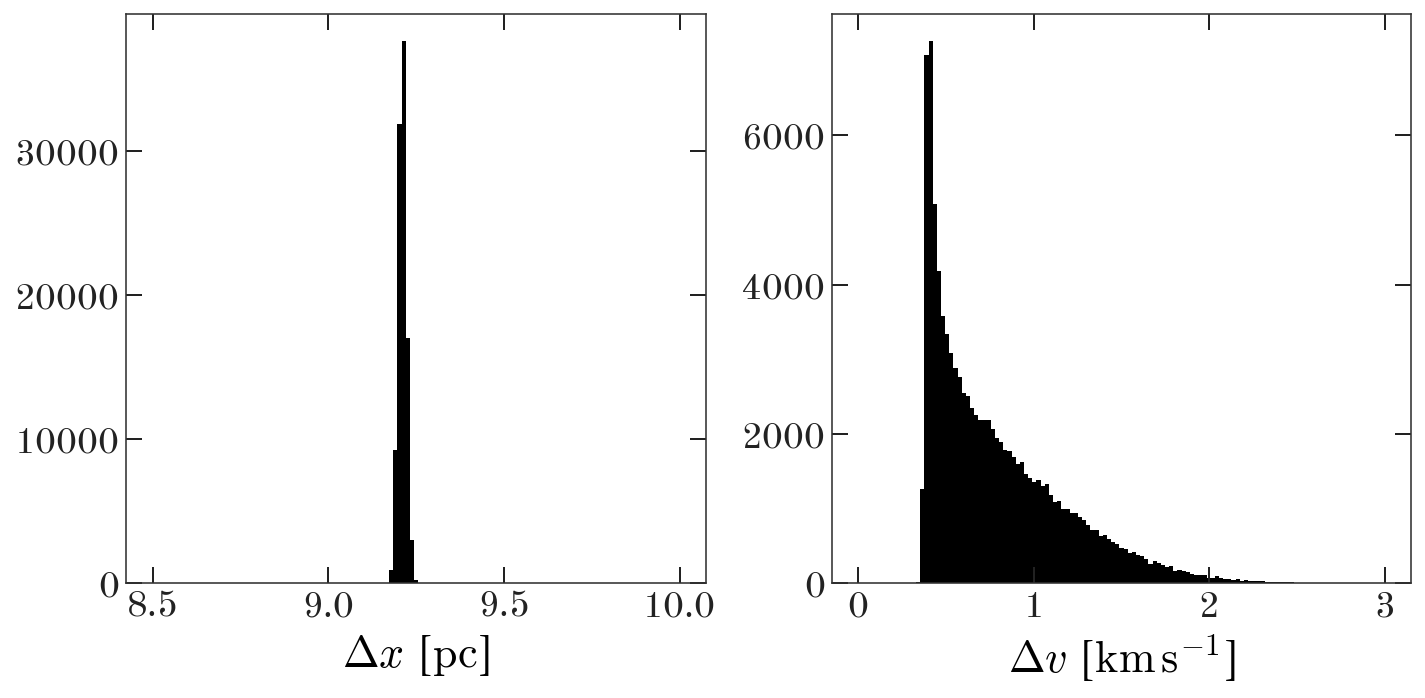

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10 ,5))

axes[0].hist(dx.to_value(u.pc)[0], np.linspace(8.5, 10, 128));
axes[0].set_xlabel(rf'$\Delta x$ [{u.pc:latex_inline}]')

axes[1].hist(dv.to_value(u.km/u.s)[0], np.linspace(0, 3, 128));
axes[1].set_xlabel(rf'$\Delta v$ [{u.km/u.s:latex_inline}]')

fig.set_facecolor('w')
fig.tight_layout()

In [18]:
mw = gp.MilkyWayPotential()
_ = coord.galactocentric_frame_defaults.set('v4.0')

In [19]:
w1 = gd.PhaseSpacePosition(
    g1.get_error_samples(size=1_000).get_skycoord().transform_to(coord.Galactocentric()).data)
w2 = gd.PhaseSpacePosition(
    g2.get_error_samples(size=1_000).get_skycoord().transform_to(coord.Galactocentric()).data)

In [20]:
orbit1 = mw.integrate_orbit(w1, dt=-0.2*u.Myr, t1=0, t2=-100*u.Myr,
                            Integrator=gi.DOPRI853Integrator)
orbit2 = mw.integrate_orbit(w2, t=orbit1.t,
                            Integrator=gi.DOPRI853Integrator)

In [21]:
# _ = orbit1[:, :10].plot()
# _ = orbit2[:, :10].plot()

In [22]:
dx = (orbit1.pos - orbit2.pos).norm()
dx.shape

(501, 1000)

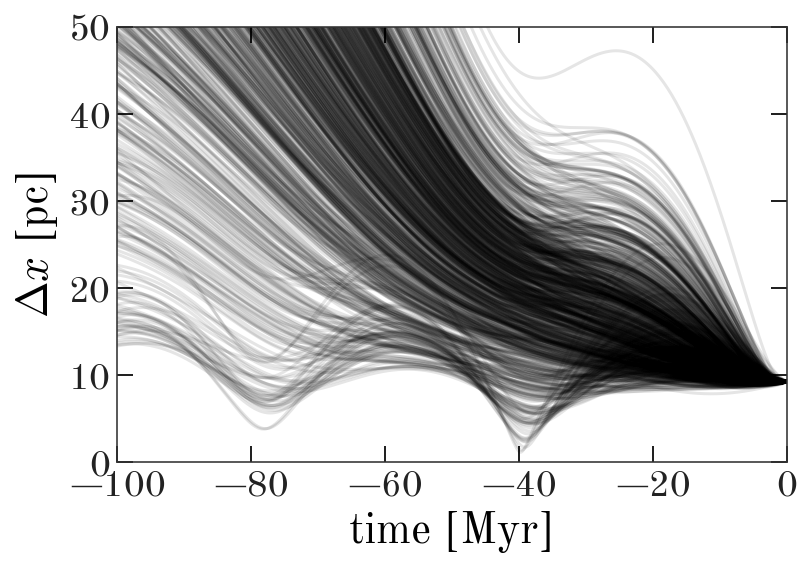

In [23]:
fig = plt.figure()
plt.plot(orbit1.t.to_value(u.Myr), dx.to_value(u.pc),
         marker='', alpha=0.1, color='k')
plt.ylim(0, 50)
plt.xlim(-100, 0)
plt.xlabel('time [Myr]')
plt.ylabel(r'$\Delta x$ [pc]')
fig.set_facecolor('w')

Check for alignment of ∆x and ∆v:

In [24]:
dxnorm = orbit1.pos / orbit1.pos.norm()
dvnorm = orbit1.vel / orbit1.vel.norm()

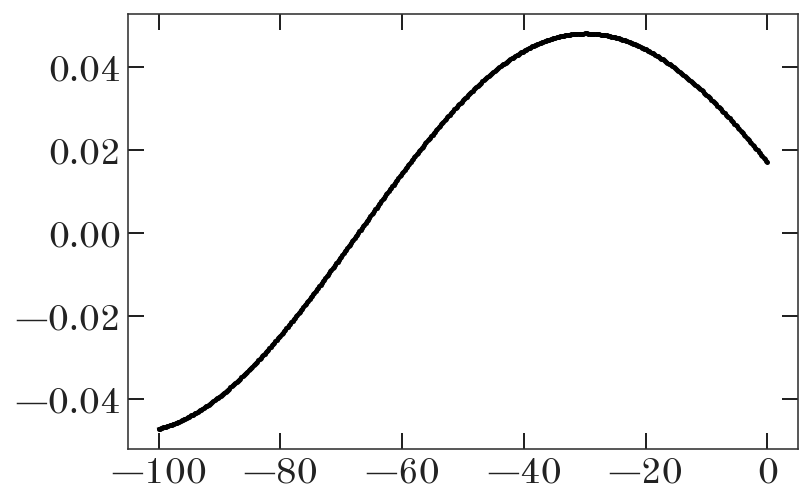

In [30]:
plt.plot(orbit1.t, dxnorm[:, 0].dot(dvnorm[:, 0]))

---

Other stars on the sky:

In [37]:
g = GaiaData.from_query("""
SELECT * FROM gaiadr2.gaia_source as gaia
WHERE parallax > 15
AND radial_velocity IS NOT NULL
AND 1=CONTAINS(
  POINT('ICRS', gaia.ra, gaia.dec),
  CIRCLE('ICRS', 210, 39.79039914276253, 120)
)
""")

INFO: Query finished. [astroquery.utils.tap.core]


In [38]:
len(g)

19607

In [39]:
gplx = g[(g.parallax_over_error > 6) & np.isfinite(g.radial_velocity)]
len(gplx)

19607

In [40]:
cc = gplx.get_skycoord()

In [43]:
dx = cc.data.to_cartesian() - c1.data.to_cartesian()
dv = cc.velocity - c1.velocity

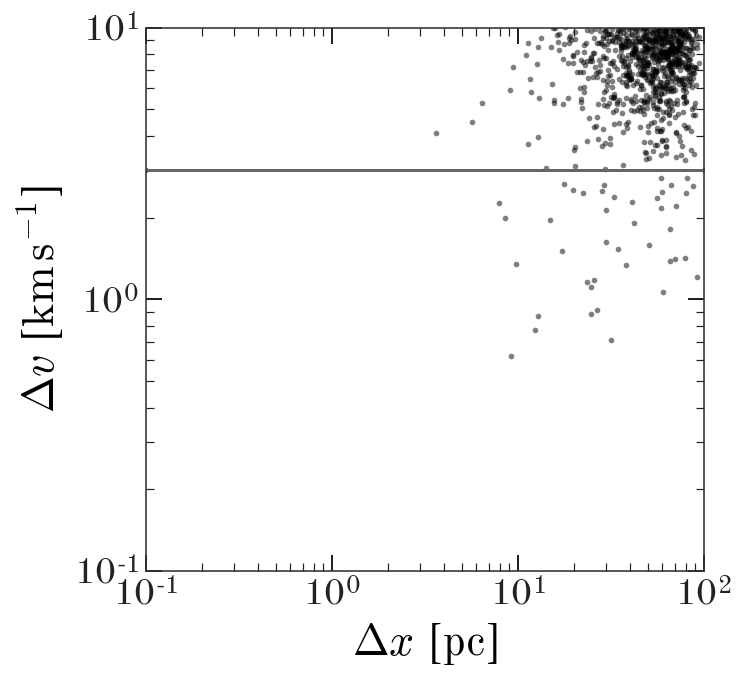

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(dx.norm().to_value(u.pc), 
           dv.norm().to_value(u.km/u.s),
           lw=0, s=8, alpha=0.5)

ax.set(xscale='log',
       yscale='log',
       xlim=(1e-1, 100),
       ylim=(1e-1, 10),
       xlabel=r'$\Delta x$ [pc]',
       ylabel=rf'$\Delta v$ [{u.km/u.s:latex_inline}]');

ax.axhline(3.)

In [197]:
(0.65*u.km/u.s * 40*u.Myr).to(u.pc)

<Quantity 26.59051629 pc>

In [46]:
derp = gplx[(dv.norm() < 3*u.km/u.s) & 
            (dx.norm() < 80*u.pc) & 
            (gplx.distance > 30*u.pc) & (gplx.distance < 50*u.pc)]
derp.data['source_id', 'ra', 'dec', 'parallax', 'phot_g_mean_mag'].pprint(max_width=100000)

     source_id              ra                 dec              parallax      phot_g_mean_mag
                           deg                 deg                mas               mag      
------------------- ------------------ ------------------- ------------------ ---------------
1263985102569989504 229.81268749648024   24.32704916428149 21.576488596501346       10.575995
1203627102528283392 237.91272641153859   18.67311488986952  20.59452180481214       12.138924
3521740279252141952 185.91580981772316 -14.989144291556924 26.714821830525498       12.261337
3958028490314315008 192.90936616579543  25.508668441639546 25.810851782449188         8.84079
1948709198586896384 329.90339801633013   35.68406738393206  22.86988397705063        9.256124
1291109504671837824 229.68592452337364    35.9487650003791  21.03852903760748      11.0706215
1396617472242087168 236.59598828904848    44.0541780289445 21.474647851489603       11.226857
3978500258656158720  171.6127911930363   20.51782247355513 2

In [47]:
ebv = derp.get_ebv()

In [88]:
# bprp = derp.phot_bp_mean_mag - derp.phot_rp_mean_mag
# gmag = derp.phot_g_mean_mag

bprp = derp.get_BP0() - derp.get_RP0()
gmag = derp.get_G0()

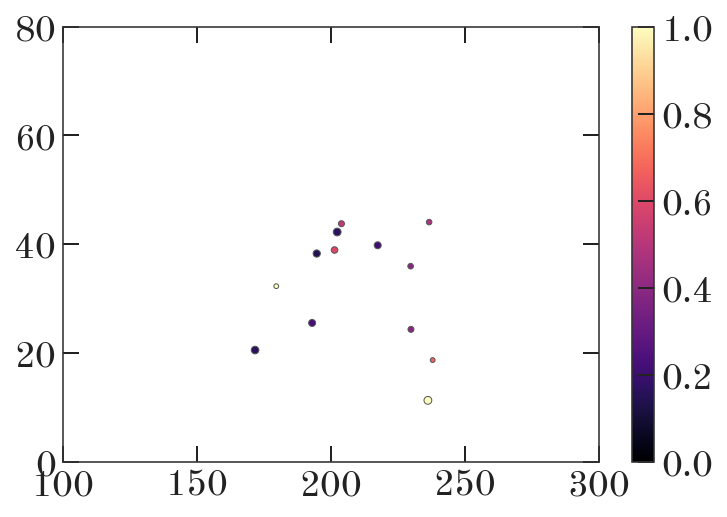

In [89]:
cs = plt.scatter(derp.ra.value, derp.dec.value,
                 c=derp.radial_velocity_error,
                 vmin=0, vmax=1, zorder=100, lw=0.5, 
                 edgecolor='#555555', 
                 s=2 * (15 - derp.phot_g_mean_mag.value))
#                  c=1000/derp.parallax.value,
#                  vmin=40, vmax=60, lw=0.5, 
#                  edgecolor='#555555')
plt.xlim(100, 300)
plt.ylim(0, 80)
plt.colorbar(cs)

In [50]:
# [Fe/H] = -0.07 from Bochanski
iso = at.Table.read('/Users/apricewhelan/data/Isochrones/MIST/FeH_0.0_iso.fits')
iso = iso[iso['phase'] < 1]
iso = iso[(iso['log10_isochrone_age_yr'] > 7.5) & (iso['log10_isochrone_age_yr'] < 8.3)]

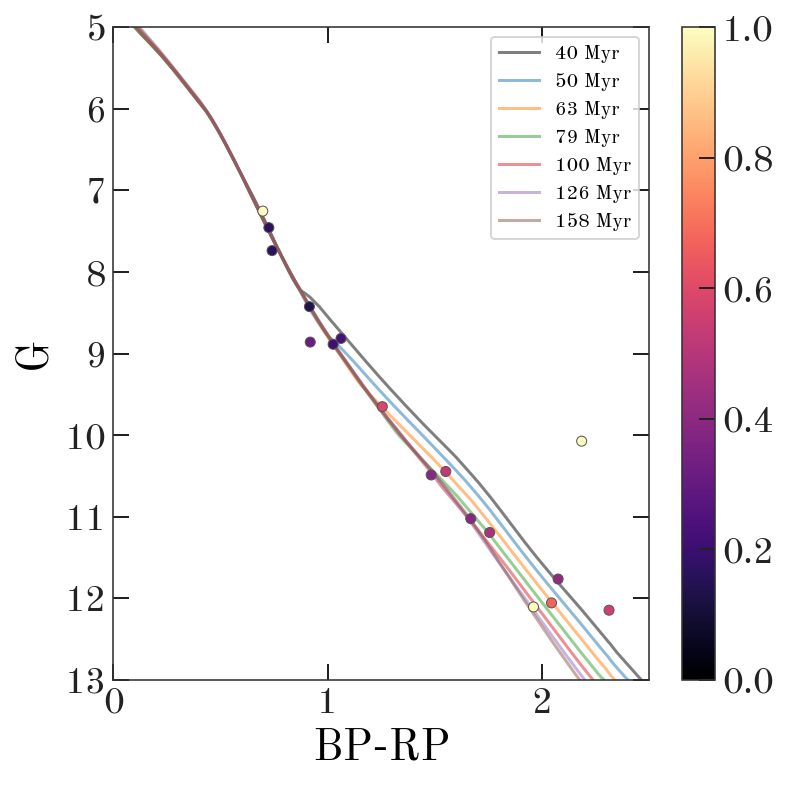

In [90]:
fig, ax = plt.subplots(figsize=(6, 6))
# ax.scatter(bprp, gmag,
#            c=1000/derp.parallax.value,
#            vmin=40, vmax=60, zorder=100, lw=0.5, 
#            edgecolor='#555555')

cc = ax.scatter(bprp, gmag,
                c=derp.radial_velocity_error,
                vmin=0, vmax=1, zorder=100, lw=0.5, 
                edgecolor='#555555')
fig.colorbar(cc)

for age in np.unique(iso['log10_isochrone_age_yr']):
    i = iso[iso['log10_isochrone_age_yr'] == age]
    ax.plot(i['G_BP'] - i['G_RP'], 
            i['G'] + g1.distmod.value - 0.1,
            marker='', alpha=0.5, label=f'{10**age / 1e6:.0f} Myr')

ax.set(xlabel='BP-RP',
       ylabel='G',
       xlim=(0., 2.5),
       ylim=(13, 5))

ax.legend()
fig.set_facecolor('w')

This one is a no!

In [161]:
hd140667 = derp[gmag < 8*u.mag]
hd140667_c = hd140667.get_skycoord()

hd140667_c = coord.SkyCoord(ra=hd140667_c.ra, dec=hd140667_c.dec,
                            distance=hd140667_c.distance,
                            pm_ra_cosdec=hd140667_c.pm_ra_cosdec,
                            pm_dec=hd140667_c.pm_dec,
                            radial_velocity=-16.727*u.km/u.s) # SB9 COM velocity

In [168]:
(hd140667_c.velocity - derp_c.velocity).norm()

<Quantity [2.24627485, 1.83008836, 1.1408275 , 1.39057102, 1.24599308,
           1.62228132, 1.07861597] km / s>

In [163]:
hd140667_w = gd.PhaseSpacePosition(hd140667_c.transform_to(coord.Galactocentric()).data)
hd_orbit = mw.integrate_orbit(hd140667_w, t=orbit1.t)

Rewind all orbits?

In [52]:
derp_w = gd.PhaseSpacePosition(
    derp.get_error_samples(size=1_000).get_skycoord().transform_to(coord.Galactocentric()).data)

In [53]:
derp_orbit = mw.integrate_orbit(derp_w, t=orbit1.t)

In [54]:
derp_dx = (orbit1.pos[:, None] - derp_orbit.pos.reshape((len(orbit1.t),) + derp_w.shape)).norm()
# derp_dx = (hd_orbit.pos[:, None, None] - derp_orbit.pos.reshape((len(orbit1.t),) + derp_w.shape)).norm()
derp_dx.shape

(501, 17, 1000)

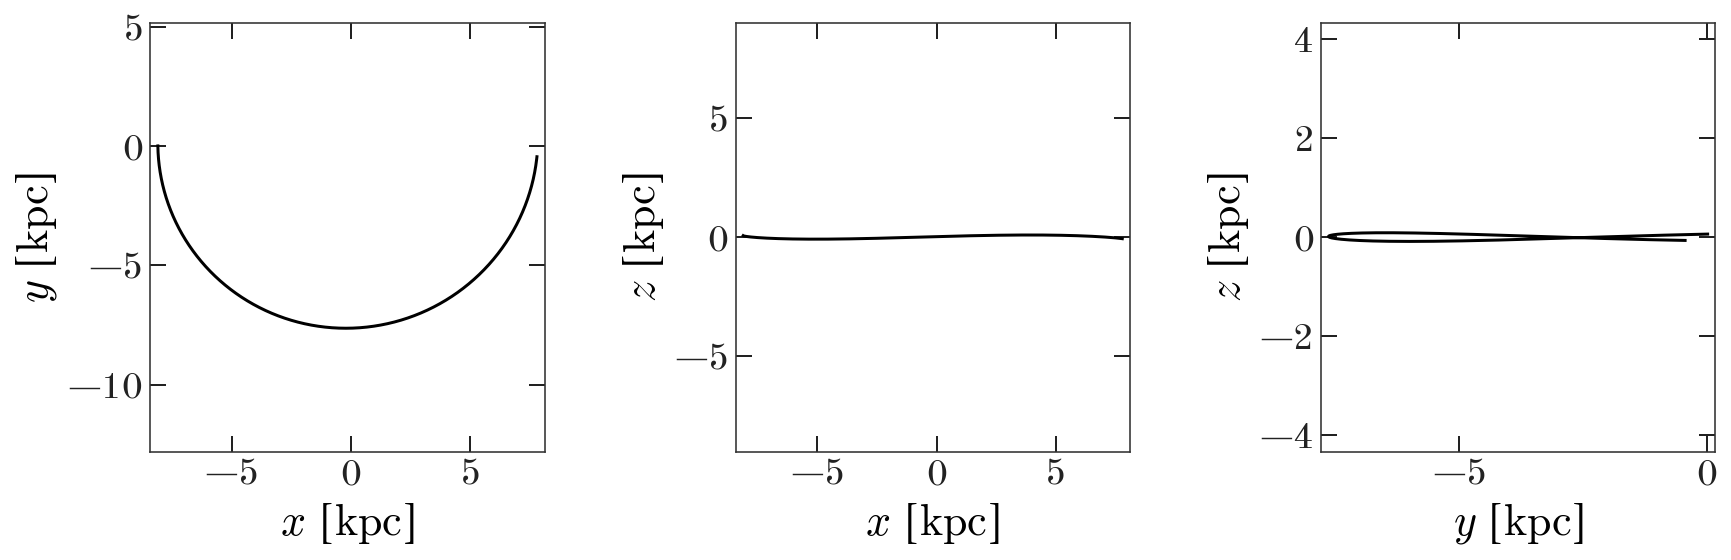

In [55]:
_ = orbit1[:, 0].plot()

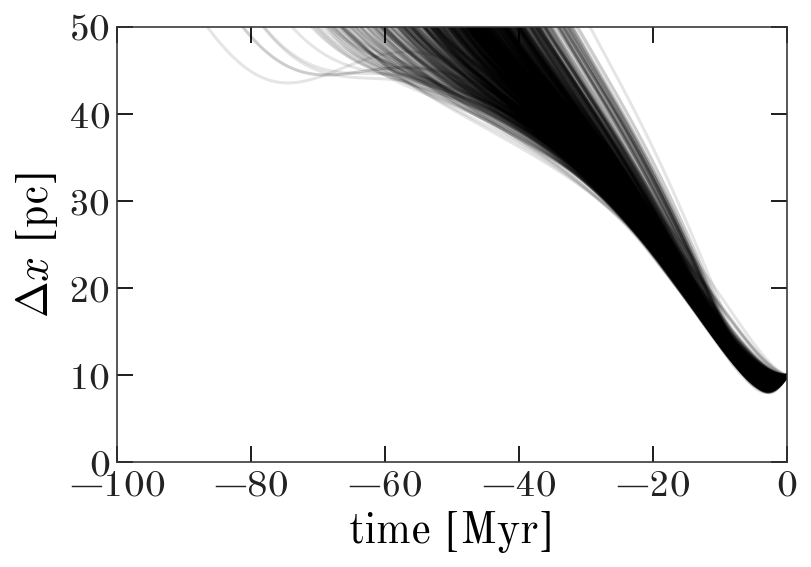

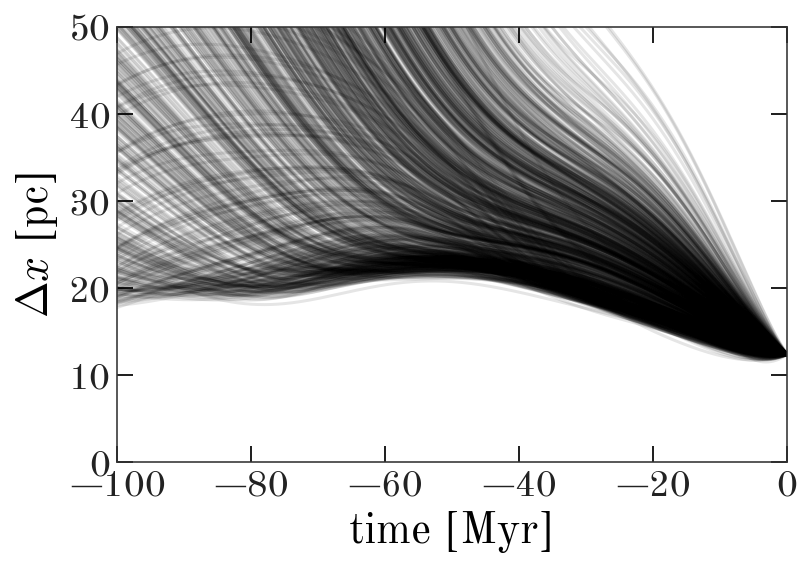

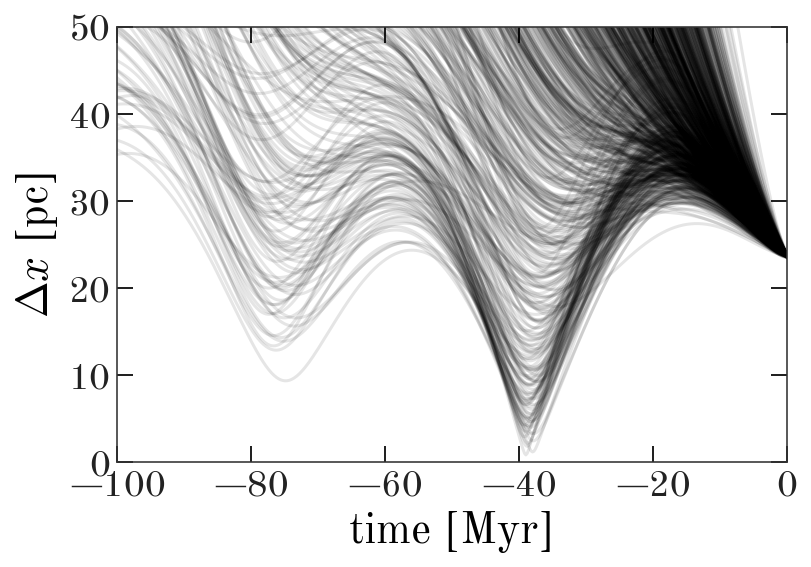

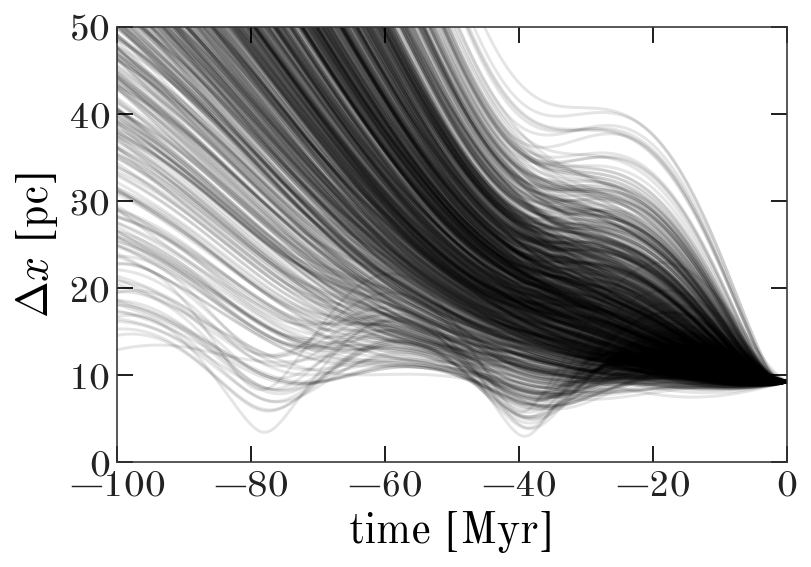

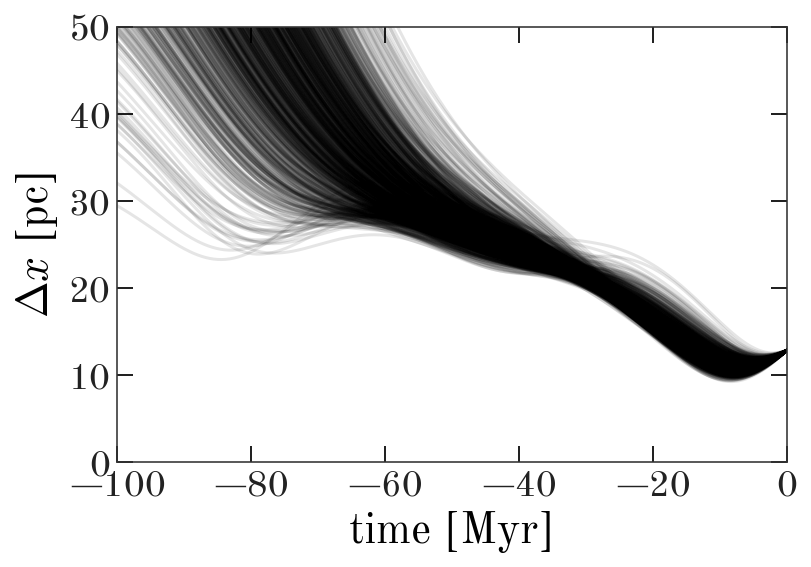

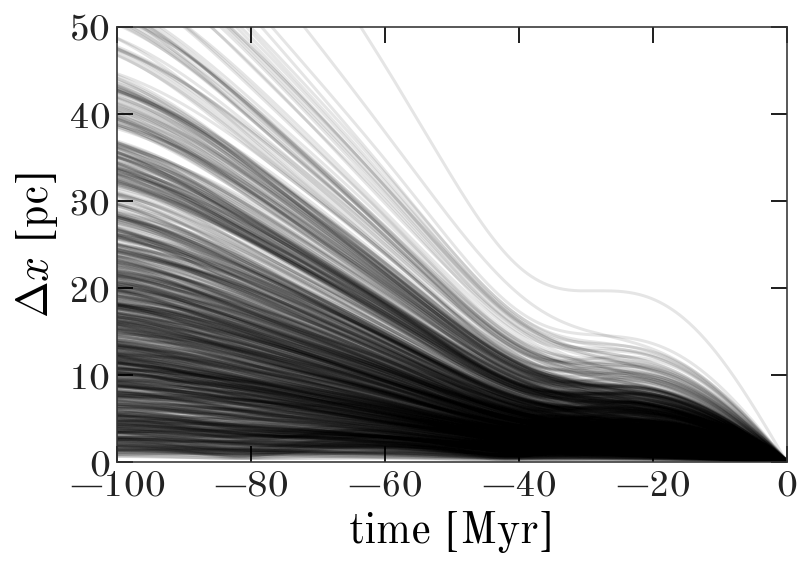

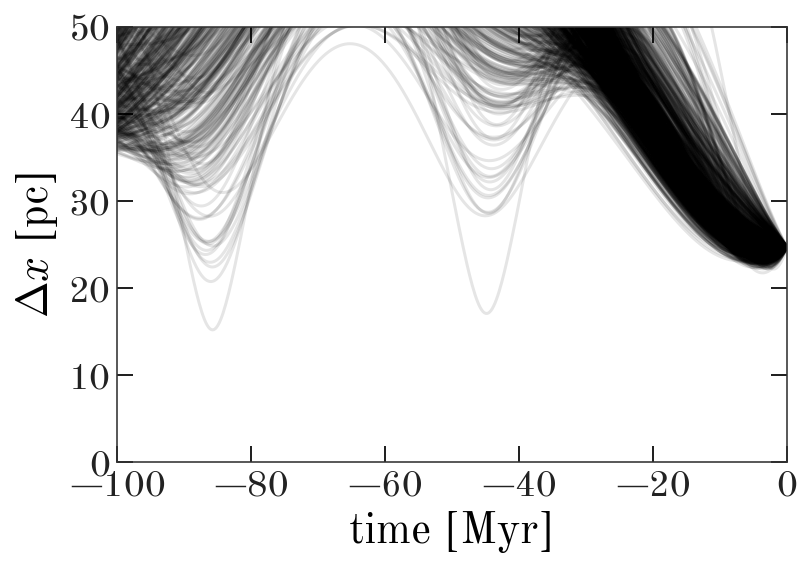

In [208]:
for i in range(derp_dx.shape[1]):
    fig = plt.figure()
    plt.plot(orbit1.t.to_value(u.Myr), 
             derp_dx[:, i].to_value(u.pc),
             marker='', alpha=0.1, color='k')
    plt.ylim(0, 50)
    plt.xlim(-100, 0)
    plt.xlabel('time [Myr]')
    plt.ylabel(r'$\Delta x$ [pc]')
    fig.set_facecolor('w')

## Any APOGEE data?

In [60]:
rave = at.Table.read('/Users/apricewhelan/data/RAVE/rave_gaia_xmatch.fits')

In [59]:
lamost = at.Table.read('/Users/apricewhelan/data/LAMOST/DDPayne_LAMOST-DR5_recommend.fits')

In [79]:
allstar = at.Table.read('/Users/apricewhelan/data/APOGEE_beta/apogee_astroNN-r13-l33-58932beta.fits')

In [63]:
lamost_c = coord.SkyCoord(lamost['RA'], lamost['DEC'], unit='deg')

In [95]:
derp_c = derp.get_skycoord()
lamost_idx, lamost_sep, _ = derp_c.match_to_catalog_sky(lamost_c)
lamost_data = lamost[lamost_idx[lamost_sep < 2*u.arcsec]]
lamost_data['source_id'] = derp.data[lamost_sep < 2*u.arcsec]['source_id']

In [69]:
derp.data['has_apogee'] = np.isin(derp.source_id, allstar['source_id'])
derp.data['has_rave'] = np.isin(derp.source_id, rave['source_id'])
derp.data['has_lamost'] = (lamost_sep < 2*u.arcsec)

In [75]:
subtbl = derp.data['source_id', 'ra', 'dec', 'phot_g_mean_mag', 'has_apogee', 'has_lamost', 'has_rave']
subtbl[np.argsort(subtbl['phot_g_mean_mag'])].pprint(max_width=100000)

     source_id              ra                 dec         phot_g_mean_mag has_apogee has_lamost has_rave
                           deg                 deg               mag                                     
------------------- ------------------ ------------------- --------------- ---------- ---------- --------
1189404610382948224  236.1322036518831  11.266318068298254       7.3758554      False      False    False
1549259098113618688 202.26291000634765   42.23818452959808       7.4919796      False      False    False
3978500258656158720  171.6127911930363   20.51782247355513        7.787809      False      False    False
1523645047031954944 194.63248593814353   38.27857676798752        8.472794      False      False    False
3958028490314315008 192.90936616579543  25.508668441639546         8.84079       True      False    False
1490845584382687232 217.39201591534362   39.79039914276253        8.910282      False      False    False
1948709198586896384 329.90339801633013   35.68

In [87]:
stars = allstar[np.isin(allstar['source_id'], derp.source_id)]
stars['source_id', 'FE_H', 'FE_H_ERR', 'MG_H', 'SI_H', 'age']

source_id,FE_H,FE_H_ERR,MG_H,SI_H,age
int64,float32,float32,float32,float32,float64
3958028490314315008,0.083181605,0.035630614,0.11412954,0.024622275,6.8826446533203125
1501788130259330688,-0.014850561,0.04481705,0.047888543,-0.071233094,9.525585174560547
1396617472242087168,-0.32415643,0.074685596,-0.1845993,-0.28445444,8.595919609069824


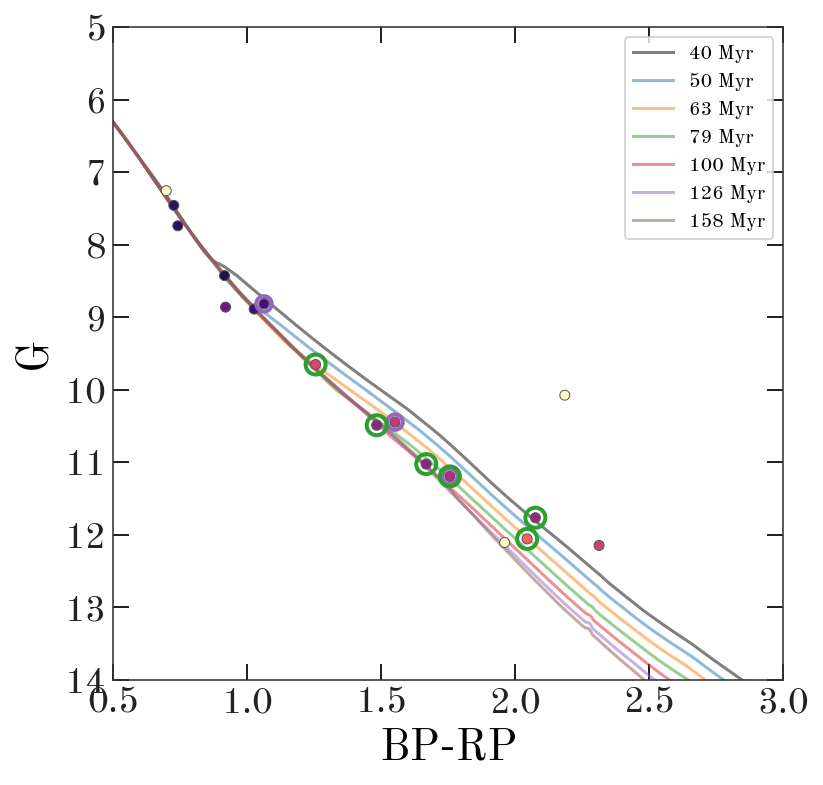

In [92]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(bprp, gmag,
           c=derp.radial_velocity_error,
           vmin=0, vmax=1, zorder=100, lw=0.5, 
           edgecolor='#555555')
#            c=1000/derp.parallax.value,
#            vmin=40, vmax=50, zorder=100, lw=0.5, 
#            edgecolor='#555555')

ax.scatter(bprp[derp.has_apogee], 
           gmag[derp.has_apogee], zorder=200, lw=2, 
           facecolor='none', color='tab:purple', s=60)

ax.scatter(bprp[derp.has_lamost], 
           gmag[derp.has_lamost], zorder=200, lw=2, 
           facecolor='none', color='tab:green', s=100)

for age in np.unique(iso['log10_isochrone_age_yr']):
    i = iso[iso['log10_isochrone_age_yr'] == age]
    ax.plot(i['G_BP'] - i['G_RP'], 
            i['G'] + g1.distmod.value - 0.1,
            marker='', alpha=0.5, label=f'{10**age / 1e6:.0f} Myr')

ax.set(xlabel='BP-RP',
       ylabel='G',
       xlim=(0.5, 3),
       ylim=(14, 5))

ax.legend()
fig.set_facecolor('w')

In [96]:
lamost_data

SPECID,RA,DEC,SNR_U,SNR_G,SNR_R,SNR_I,SNR_Z,RV,RV_ERR,TEFF,TEFF_ERR,TEFF_FLAG,TEFF_GRADCORR,LOGG,LOGG_ERR,LOGG_FLAG,LOGG_GRADCORR,VMIC,VMIC_ERR,VMIC_FLAG,VMIC_GRADCORR,FEH,FEH_ERR,FEH_FLAG,FEH_GRADCORR,ALPHA_FE,ALPHA_FE_ERR,C_FE,C_FE_ERR,C_FE_FLAG,C_FE_GRADCORR,N_FE,N_FE_ERR,N_FE_FLAG,N_FE_GRADCORR,O_FE,O_FE_ERR,O_FE_FLAG,O_FE_GRADCORR,NA_FE,NA_FE_ERR,NA_FE_FLAG,NA_FE_GRADCORR,MG_FE,MG_FE_ERR,MG_FE_FLAG,MG_FE_GRADCORR,AL_FE,AL_FE_ERR,AL_FE_FLAG,AL_FE_GRADCORR,SI_FE,SI_FE_ERR,SI_FE_FLAG,SI_FE_GRADCORR,CA_FE,CA_FE_ERR,CA_FE_FLAG,CA_FE_GRADCORR,TI_FE,TI_FE_ERR,TI_FE_FLAG,TI_FE_GRADCORR,CR_FE,CR_FE_ERR,CR_FE_FLAG,CR_FE_GRADCORR,MN_FE,MN_FE_ERR,MN_FE_FLAG,MN_FE_GRADCORR,CO_FE,CO_FE_ERR,CO_FE_FLAG,CO_FE_GRADCORR,NI_FE,NI_FE_ERR,NI_FE_FLAG,NI_FE_GRADCORR,CU_FE,CU_FE_ERR,CU_FE_FLAG,CU_FE_GRADCORR,BA_FE,BA_FE_ERR,BA_FE_FLAG,BA_FE_GRADCORR,CHI2,CHI2RATIO,QFLAG_CHI2,CHI2_NA,CHI2RATIO_NA,QFLAG_CHI2NA,SNR_DPARALLAX,FLAG_SINGLESTAR,UQFLAG,STARID,SUBCLASS,FILENAME,source_id
bytes36,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,bytes4,float32,float32,bytes4,float32,bytes3,int16,bytes15,bytes10,bytes48,int64
20140507-HD152134N242036V01-04-158,229.813113,24.327078,30.05,250.27,432.14,630.17,558.65,-21.111385,4.2000923,4505.419,9.990666,1,0.8245956,4.5671816,0.019368555,1,0.82512957,1.2129099,0.026897656,0,0.37276754,-0.27543056,0.015480791,1,0.874913,0.1041042,0.0043357806,-0.16718066,0.0071441256,1,0.80098355,0.16746083,0.020915769,1,0.6220519,0.32093525,0.019919006,1,0.65733963,0.07055594,0.016935514,1,0.5571066,-0.075502306,0.008607967,1,0.64789015,0.1978444,0.012572831,1,0.57712555,-0.094955675,0.010447168,1,0.5269506,0.24830356,0.0083931545,1,0.7271673,0.2387853,0.007822819,1,0.6225076,0.13023652,0.0068342406,1,0.7694648,-0.27158368,0.010818065,1,0.82541853,0.040575847,0.01465216,1,0.60730314,-0.021154206,0.008486208,1,0.6552518,-999.0,999.0,0,0.23756261,0.6754837,0.03073067,1,0.69038165,34.944733,5.334386,good,46.90553,1.8272843,good,0.087719835,YES,1,S2294847+241937,K5,spec-56785-HD152134N242036V01_sp04-158.fits.gz,1263985102569989504
20150523-HD154844N180829V01-09-152,237.913024,18.673151,0.55,13.51,63.67,123.48,106.8,-8.502114,2.6561613,4236.7134,27.876293,0,0.77254385,4.8067455,0.06961404,0,0.76040345,-0.060004618,0.080638245,0,0.19822209,-0.98118097,0.047479432,0,0.7464045,0.10545846,0.025441464,-999.0,999.0,0,0.6879784,-999.0,999.0,0,0.5289627,-999.0,999.0,0,0.54739904,-999.0,999.0,0,0.43211383,-999.0,999.0,0,0.35076407,-999.0,999.0,0,0.36481658,-999.0,999.0,0,0.4160775,-999.0,999.0,0,0.65868735,-999.0,999.0,0,0.3989938,-999.0,999.0,0,0.63137466,-999.0,999.0,0,0.6790402,-999.0,999.0,0,0.41592145,-999.0,999.0,0,0.51427376,-999.0,999.0,0,0.21025485,-999.0,999.0,0,0.57303303,5.134489,12.102637,bad,25.643782,48.14055,bad,0.0,YES,1,S2375446+184023,M1,spec-57166-HD154844N180829V01_sp09-152.fits.gz,1203627102528283392
20150218-HD151157N364516V01-06-247,229.686404,35.948736,4.17,69.62,156.36,219.89,180.77,-19.210701,4.0801754,4349.378,19.119658,0,0.77899015,4.47512,0.032086965,0,0.80342627,0.90878534,0.053275634,0,0.23580909,-0.50868183,0.02868742,0,0.81516814,0.1722185,0.009419695,-999.0,999.0,0,0.72284037,-999.0,999.0,0,0.53436077,-999.0,999.0,0,0.60847735,-999.0,999.0,0,0.46104413,-999.0,999.0,0,0.57753325,-999.0,999.0,0,0.5439565,-999.0,999.0,0,0.500239,-999.0,999.0,0,0.64824057,-999.0,999.0,0,0.5864488,-999.0,999.0,0,0.

In [71]:
(10**i[i['G'] < 12.5]['log_Teff']).min()

3049.2547713347285

---

In [36]:
from astropy.time import Time

In [35]:
loc = coord.EarthLocation.of_site('APO')

In [220]:
t = Time.now() + np.linspace(0, 16, 128)*u.hour
altaz = derp_c[None].transform_to(coord.AltAz(obstime=t,
                                              location=loc)[:, None])

(array([737602.41666667, 737602.5       , 737602.58333333, 737602.66666667,
        737602.75      , 737602.83333333, 737602.91666667, 737603.        ,
        737603.08333333]),
 <a list of 9 Text major ticklabel objects>)

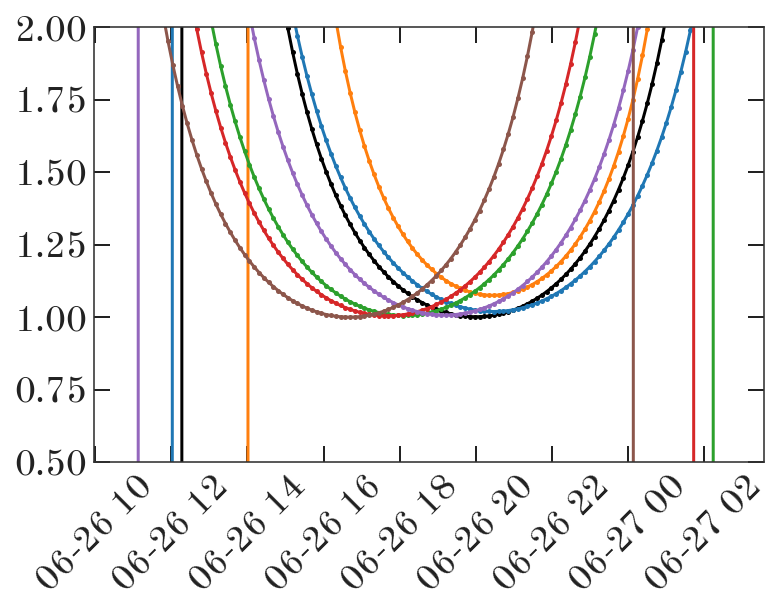

In [240]:
plt.plot((t - 8*u.hr).datetime, altaz.secz)
plt.ylim(0.5, 2)
plt.xticks(rotation=45)